<a href="https://colab.research.google.com/github/edraalfig/pm4py/blob/main/alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pm4py

In [ ]:
import pandas as pd

fn = '/content/drive/MyDrive/eventlogs/ArtificialPatientTreatment.csv'
events = pd.read_csv(fn)

events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()

,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [ ]:
from pm4py.objects.conversion.log import converter as log_converter
eventlog = events.copy()

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)

# DESCUBRIMIENTO

## DFG (Grafo de Seguimiento Directo)

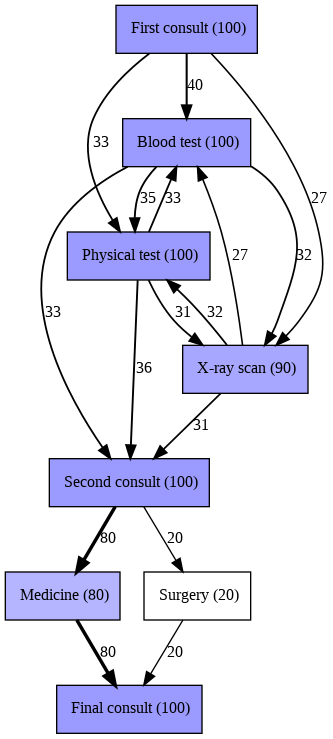

In [ ]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

## Minero Alpha

/usr/local/lib/python3.7/dist-packages/pm4py/visualization/petrinet/__init__.py:20: UserWarning: please use the pm4py.visualization.petri_net package instead
  warnings.warn("please use the pm4py.visualization.petri_net package instead")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  """


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

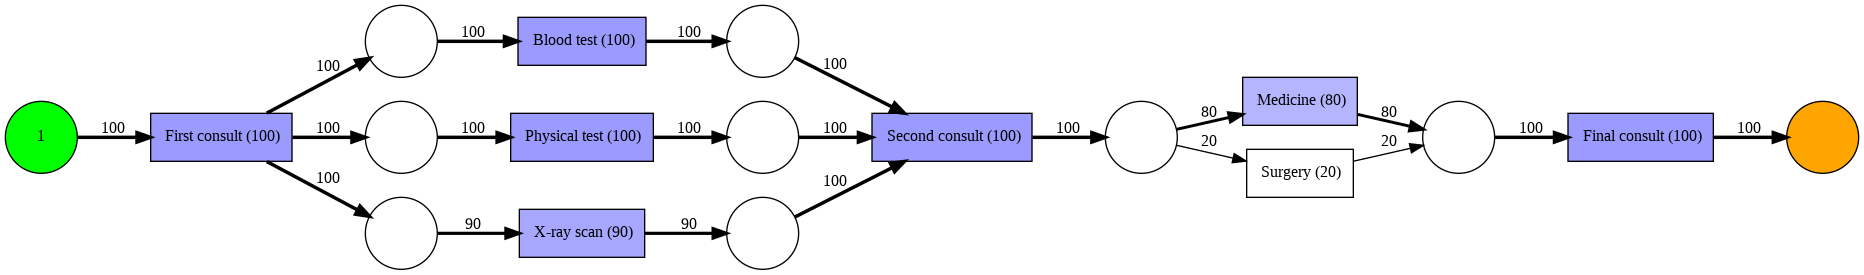

In [ ]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, im, fm = alpha_miner.apply(log)

from pm4py.visualization.petrinet import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net, im, fm,variant=pn_visualizer.Variants.FREQUENCY,log=log)
#pn_visualizer.view(gviz)
pn_visualizer.view(gviz)

# CONFORMANCE CHECKING

##Reproduccion Basada en Tokens

In [ ]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics
parameters_tbr = {
    token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, 
    token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True
}

In [ ]:
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, net, im, fm, parameters=parameters_tbr)

replaying log with TBR, completed variants ::   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(log, trans_fitness)

In [ ]:
len(trans_diagnostics)

1

In [ ]:
for trans in trans_diagnostics:
    print(trans, trans_diagnostics[trans])

( Second consult, ' Second consult') {'n_fit': 90, 'n_underfed': 10, 'fit_median_time': 853679.5, 'underfed_median_time': 621839.0, 'relative_throughput': 0.7284220834634075}


##Alineaciones

In [ ]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
aligned_traces = alignments.apply_log(log, net, im, fm)

aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
aligned_traces[0]

{'alignment': [(' First consult', ' First consult'),
  ('>>', ' X-ray scan'),
  (' Blood test', ' Blood test'),
  (' Physical test', ' Physical test'),
  (' Second consult', ' Second consult'),
  (' Surgery', ' Surgery'),
  (' Final consult', ' Final consult')],
 'bwc': 130000,
 'cost': 10000,
 'fitness': 0.9230769230769231,
 'lp_solved': 2,
 'queued_states': 25,
 'traversed_arcs': 25,
 'visited_states': 7}

# LOG-MODEL EVALUATION

##Replay Fitness

In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator

###Para TBR

In [ ]:
fitnesstbr = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
fitnesstbr

{'average_trace_fitness': 0.9888888888888888,
 'log_fitness': 0.98989898989899,
 'perc_fit_traces': 90.0,
 'percentage_of_fitting_traces': 90.0}

###Para Alineaciones

In [ ]:
fitnessali = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)

aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
fitnessali

{'averageFitness': 0.9923076923076921,
 'average_trace_fitness': 0.9923076923076921,
 'log_fitness': 0.9928057553956835,
 'percFitTraces': 90.0,
 'percentage_of_fitting_traces': 90.0}

## Precisión

In [ ]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator

###Para TBR

In [ ]:
prectbr = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

In [ ]:
prectbr

0.9830188679245283

###Para Alineaciones

In [ ]:
precali = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)

computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]

In [ ]:
precali

0.9830188679245283

##Generalización

In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(log, net, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
gen

0.8823975685045107

##Simplicidad

In [ ]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)

In [ ]:
simp

0.8181818181818181